In [ ]:
import pandas as pd
import peakutils
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [ ]:
# create giant data object, to house all data
data = {}

In [ ]:
# read all the labels for the data into a df
def read_labels_for_all_houses():
    houses = []
    for house in range(1, 7):
        hi = 'Data/low_freq/house_{}/labels.dat'.format(house)
        df = pd.read_csv(hi, sep=" ", header=None, names = ["appliance_id","appliance_name"], dtype={"appliance_id":"int64","appliance_name":"string"})
        df['house_id'] = house
        houses.append(df)
    return pd.concat(houses).reset_index(drop=True)

labels = read_labels_for_all_houses()
for house in range(1,7):
    print('House {}: \n'.format(house), labels[labels['house_id'] == house] , '\n')

data['labels_for_houses'] = labels

In [ ]:
# read all the appliance data points for all houses
def read_channel_data(labels_for_houses, house_id):
    house_labels = labels_for_houses[labels_for_houses['house_id'] == house_id]
    # print(house_labels)
    df = pd.DataFrame()
    for index,row in house_labels.reset_index().iterrows():
        path = 'data/low_freq/house_{}/'.format(house_id)
        file = path + 'channel_{}.dat'.format(row['appliance_id'])
        cname = (row['house_id'], row['appliance_id'], row['appliance_name'])
        file_content = pd.read_table(file, sep = ' ', names = ['unix_time', cname], 
                                        dtype = {'unix_time': 'int64', cname:'float64'})
        if(index==0):
            df = file_content
        else:
            df = pd.merge(df, file_content, how='inner', on='unix_time')
    
    df['timestamp'] = df['unix_time'].astype("datetime64[s]")
    df = df.set_index(df['timestamp'].values)
    df.drop(['unix_time','timestamp'], axis=1, inplace=True)
    df.columns = pd.MultiIndex.from_tuples(df.columns, names=["house_id","appliance_id", "appliance_name"])
    return df

# print(data['labels_for_houses'])
data['channels'] = {}
dfs = []
for house in range(1,7):
    print('reading channels for house {}'.format(house))
    # data['channels'][house] = read_channel_data(data['labels_for_houses'], house)
    df = read_channel_data(data['labels_for_houses'], house)
    # print(df.head())
    dfs.append(df)

appliance_data = pd.concat(dfs, axis=1)
print(appliance_data.columns)
print(appliance_data.head())

In [ ]:
# example of indexing with multiindex columns


# print columns
print(appliance_data.columns)

# print only names
print(appliance_data.columns.get_level_values('appliance_name'))

# print only appliance ids
print(appliance_data.columns.get_level_values('appliance_id'))


# print only ids
print(appliance_data.columns.get_level_values('house_id'))

# index using appliance name 
print(appliance_data.xs('mains',level='appliance_name', axis=1).head())

# and using appliance id
print(appliance_data.xs(2,level='appliance_id', axis=1).head())

# index column based on position
print(appliance_data.iloc[:,1].head())


In [ ]:
# extract all mains
def hours(time):
    return time.hour + time.minute/60 + time.second / (60*60)

def index_to_hours(df):
    return [hours(t) for t in df.index.time]

In [ ]:
mainss = appliance_data.xs("mains", level="appliance_name", axis=1)
timeToInt = index_to_hours(mainss)
mainss['date'] = mainss.index.date

# plot 
# for g,o in mainss.groupby('date'):
#     o = o.iloc[:,:-1]
#     # print(index_to_hours(o))
#     for i in range(len(o.columns)):
#         plt.plot(index_to_hours(o), o.iloc[:,i], label=o.columns[i])
#     plt.title(g)
#     plt.legend(loc="upper right")
#     plt.xlim([0,24])
#     plt.show()

plots = {}
fig = plt.figure()
fig.set_size_inches(20,4* (len(mainss.columns)-1))
# fig.set_size_inches(20)
for c in range(len(mainss.columns)-1):
    plots[c] = fig.add_subplot(len(mainss.columns)-1,1, c+1)

for g,o in mainss.groupby('date'):
    o = o.iloc[:,:-1]
    amount = len(o.columns)
    for i in range(amount):
        plots[i].fill_between(index_to_hours(o), o.iloc[:,i], alpha=(1/amount/5), color="blue")
        print(o.iloc[:,1].loc[datetime.datetime.fromtimestamp(1306016892) - datetime.timedelta(30):datetime.datetime.fromtimestamp(1306016892) + datetime.timedelta(30)])
        # plots[i].plot(index_to_hours(o), o.iloc[:,i], label=g, color = "blue", alpha = 0.)


for i in range(len(mainss.columns[:-1])):
    plots[i].set(xlim=[0,24], title=mainss.columns[i])
    # plots[i].legend(loc="upper right")
    # plots[i].show()`
plt.show()


In [ ]:
# resample signals
cleaned = appliance_data.resample("3s").median()
cleaned = cleaned.interpolate(method="pad", limit=5)

idx = cleaned.index

channels = {}
# channels contains lists of continuous 
for c in cleaned.columns:
    df = cleaned.loc[:,c]
    h,a,_ = c
    x = (df.shift(1).isnull() & df.notnull()).cumsum()
    # add group if at least one hour of data is available
    channels[c] = [d.dropna() for _, d in df.groupby(x) if len(d.dropna()) > 1200 ]

print(channels)


Peak at: 1.083815028901734 	Magnitude: 0.021586914649568946 	Phase: -0.637602327748538 PI
Peak at: 1.9508670520231215 	Magnitude: 0.016969983919635483 	Phase: -0.5397480764499001 PI


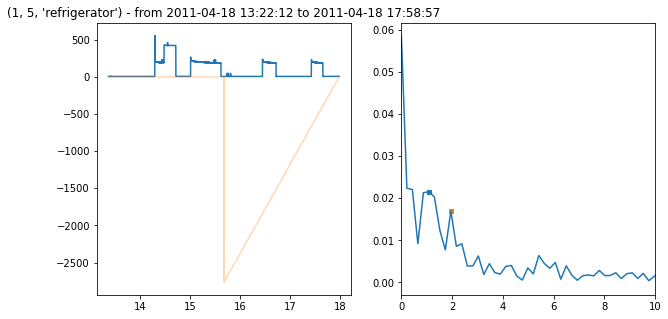

Peak at: 0.9409304756926293 	Magnitude: 0.027639119224815524 	Phase: -0.3959073571448298 PI
Peak at: 2.8227914270778878 	Magnitude: 0.012809935260719798 	Phase: -0.7639469715662119 PI


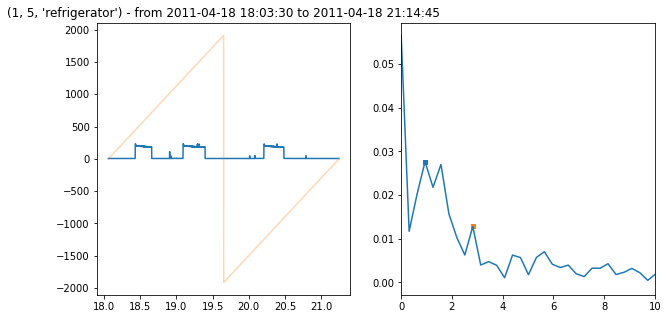

Peak at: 0.7374890254609305 	Magnitude: 0.002908880549088567 	Phase: -0.46318073191347037 PI
Peak at: 0.8955223880597014 	Magnitude: 0.0037907996367491426 	Phase: 0.6893117655120161 PI
Peak at: 1.1589113257243195 	Magnitude: 0.0021161431299420307 	Phase: 0.5043238077152251 PI
Peak at: 1.8437225636523265 	Magnitude: 0.002265778105984589 	Phase: 0.41895697109028973 PI


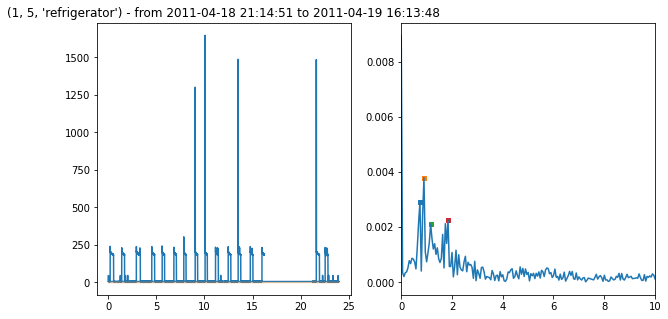

Peak at: 0.9202453987730062 	Magnitude: 0.018758297232388407 	Phase: 0.27644675237381394 PI
Peak at: 1.8404907975460123 	Magnitude: 0.012189747527522148 	Phase: 0.5615236898147364 PI
Peak at: 2.7607361963190185 	Magnitude: 0.005545594949797136 	Phase: 0.8716063776341744 PI


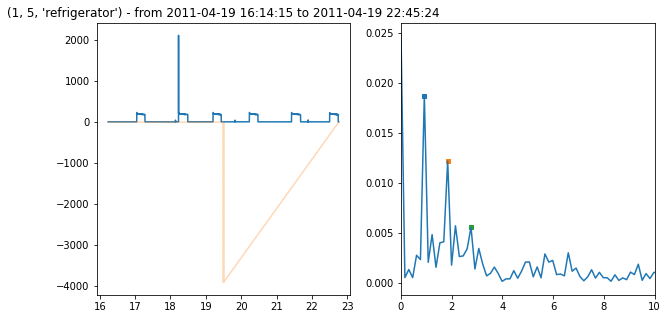

Peak at: 0.8967269466447467 	Magnitude: 0.022353185102988487 	Phase: -0.9581101131040279 PI
Peak at: 1.7934538932894935 	Magnitude: 0.016925704810454814 	Phase: 0.0864293185203134 PI
Peak at: 2.69018083993424 	Magnitude: 0.009778260956078226 	Phase: -0.8601615315115554 PI


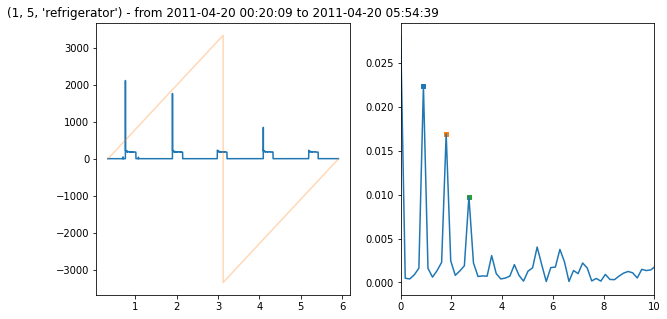

Peak at: 1.4594101550623289 	Magnitude: 0.05940212995954272 	Phase: -0.5648287235413514 PI


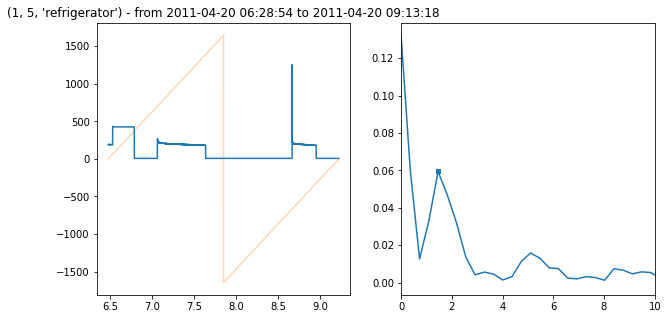

Peak at: 0.8611247497828303 	Magnitude: 0.0035563247734798275 	Phase: -0.008052935902589143 PI
Peak at: 1.7675718548173884 	Magnitude: 0.003011321744397209 	Phase: 0.9207906925789058 PI


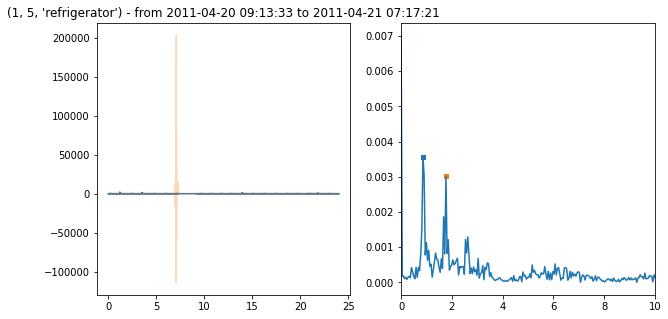

Peak at: 0.8736167734420501 	Magnitude: 0.010260452589732306 	Phase: -0.4097068938236274 PI
Peak at: 1.7472335468841003 	Magnitude: 0.007198323383487993 	Phase: -0.8177690687494138 PI
Peak at: 2.6208503203261504 	Magnitude: 0.0037108196401083814 	Phase: 0.7799289963482102 PI


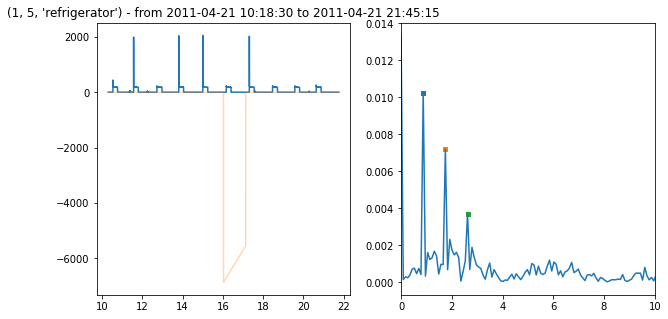

Peak at: 0.8488912127456708 	Magnitude: 0.0024434773534414444 	Phase: 0.8700464379174039 PI
Peak at: 1.6977824254913416 	Magnitude: 0.0013394025566579077 	Phase: -0.09042311642212725 PI


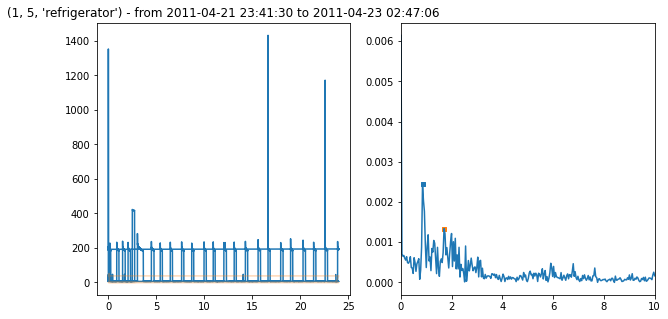

Peak at: 0.6205291734896147 	Magnitude: 0.0013950277038809443 	Phase: -0.43933051307502097 PI
Peak at: 0.8618460742911316 	Magnitude: 0.002360028861843881 	Phase: 0.5952564446879213 PI
Peak at: 1.1376368180642937 	Magnitude: 0.0014802784167677724 	Phase: 0.23273412130456064 PI
Peak at: 1.6892183056106178 	Magnitude: 0.0013525313902494815 	Phase: -0.39755148499218856 PI


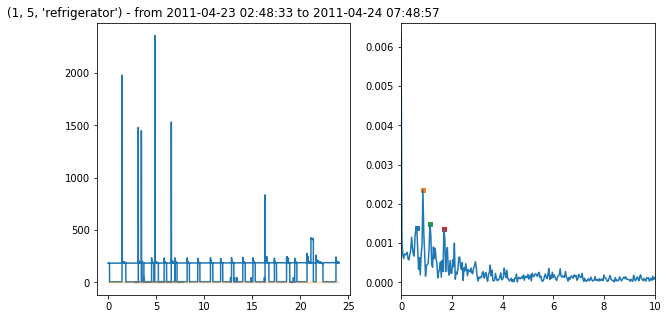

Peak at: 0.6509196705951971 	Magnitude: 0.00435223402898968 	Phase: 0.6784192267648402 PI
Peak at: 0.8284432171211599 	Magnitude: 0.003275681916948824 	Phase: 0.8916362989811247 PI
Peak at: 1.1243157946644313 	Magnitude: 0.0030850972209911964 	Phase: 0.8900356459290781 PI


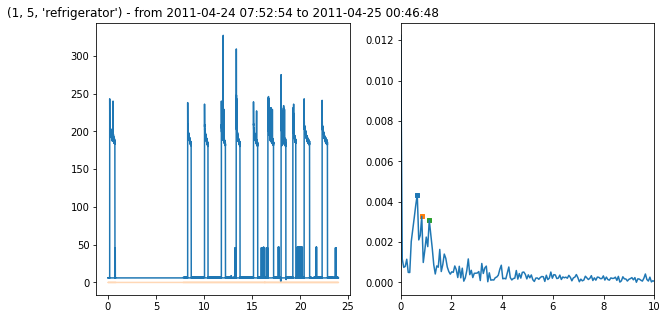

Peak at: 0.647508633448446 	Magnitude: 0.0008313529965970622 	Phase: -0.5019945288154001 PI
Peak at: 1.1655155402072028 	Magnitude: 0.0007366656934609979 	Phase: 0.7007416316998599 PI


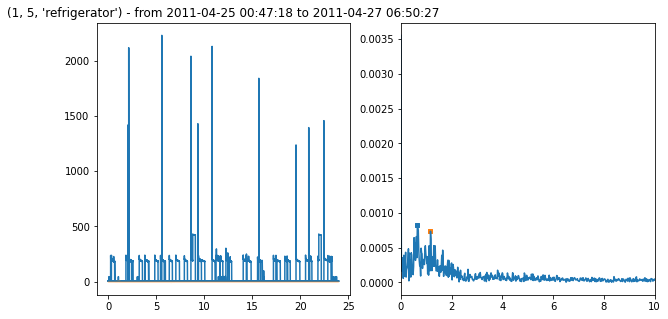

Peak at: 0.6016545500125344 	Magnitude: 0.0045349689875806695 	Phase: -0.3290658407408563 PI
Peak at: 1.2033091000250689 	Magnitude: 0.0026069806030196213 	Phase: -0.6590991523953224 PI


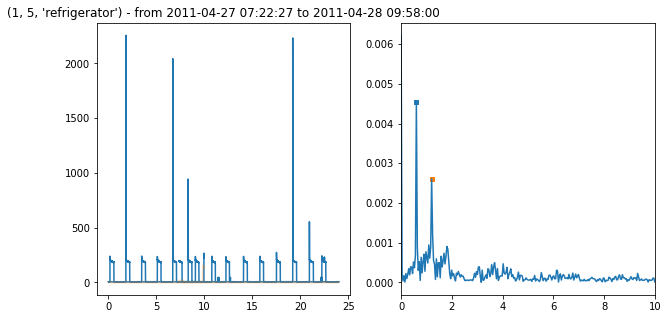

Peak at: 0.7232575520142722 	Magnitude: 0.0014698549334514778 	Phase: -0.8138846432677357 PI
Peak at: 0.8679090624171266 	Magnitude: 0.001269713195052252 	Phase: -0.6836769366295572 PI
Peak at: 1.30186359362569 	Magnitude: 0.0010640396748865394 	Phase: -0.08012132989851115 PI
Peak at: 1.5333060102702571 	Magnitude: 0.0011173702633668042 	Phase: -0.1975360144121054 PI


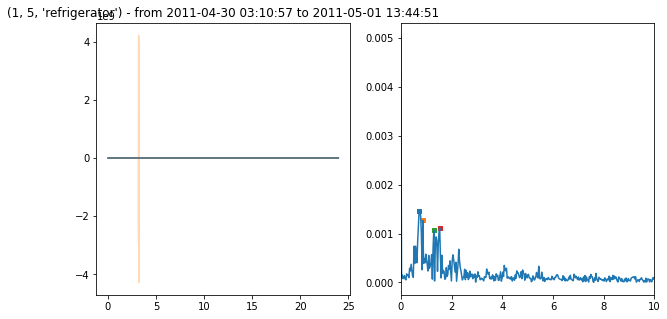

Peak at: 0.7348829778736321 	Magnitude: 0.0015680794131948364 	Phase: -0.8738197051746625 PI
Peak at: 1.150251617541337 	Magnitude: 0.0017662441298754918 	Phase: 0.5437583940440714 PI
Peak at: 1.3100087866443006 	Magnitude: 0.001175722518152924 	Phase: 0.4079969466443338 PI


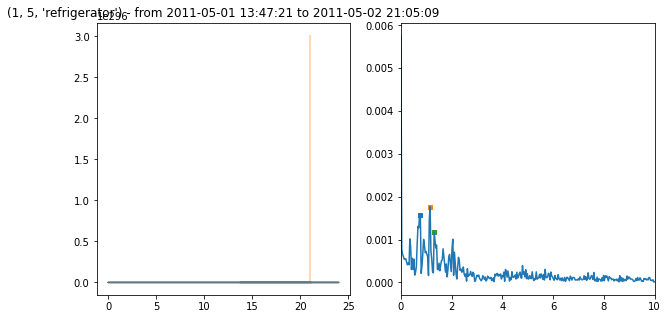

Peak at: 0.6664815329075255 	Magnitude: 0.002929308982772665 	Phase: -0.7675406298848112 PI
Peak at: 0.8092990042448525 	Magnitude: 0.002922470551987631 	Phase: 0.390756203317958 PI
Peak at: 1.332963065815051 	Magnitude: 0.00240832468579087 	Phase: 0.3571952232213328 PI
Peak at: 1.523386360931487 	Magnitude: 0.002316671226610989 	Phase: -0.14630783239891834 PI


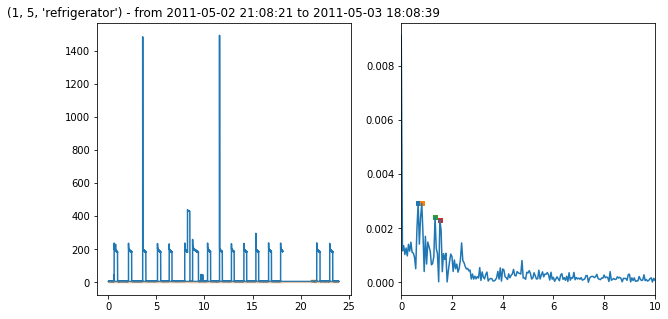

Peak at: 0.8921933085501857 	Magnitude: 0.028443334549044234 	Phase: -0.29431671250530755 PI
Peak at: 2.3791821561338287 	Magnitude: 0.013635772761150454 	Phase: 0.08214542015704819 PI


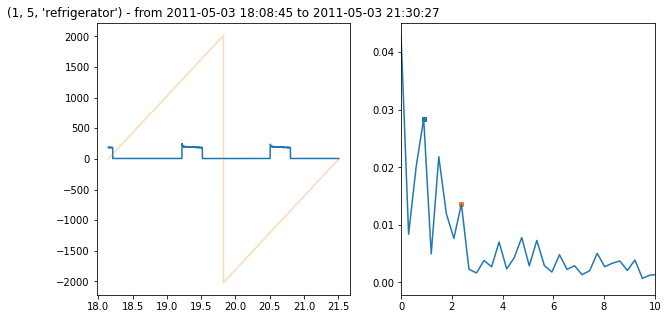

Peak at: 0.8639308855291575 	Magnitude: 0.008677605771282671 	Phase: 0.3304354062528186 PI
Peak at: 1.2566267425878654 	Magnitude: 0.0036547728588619457 	Phase: -0.704649263135092 PI
Peak at: 1.4922442568230903 	Magnitude: 0.005038470977701369 	Phase: 0.524615473362106 PI


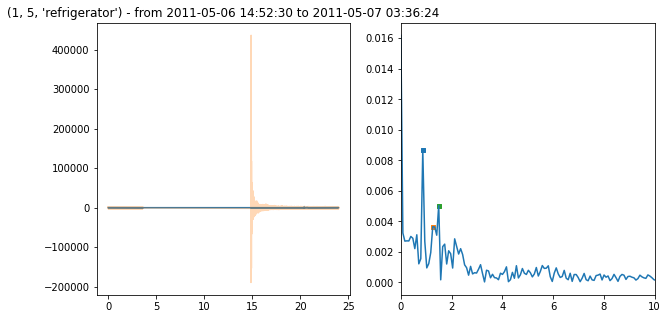

Peak at: 0.8765522279035792 	Magnitude: 0.043160581394176244 	Phase: 0.20990327754677396 PI
Peak at: 2.6296566837107376 	Magnitude: 0.018018203979140387 	Phase: 0.5417535526889106 PI
Peak at: 5.259313367421475 	Magnitude: 0.013413326332277624 	Phase: 0.5960740189516364 PI


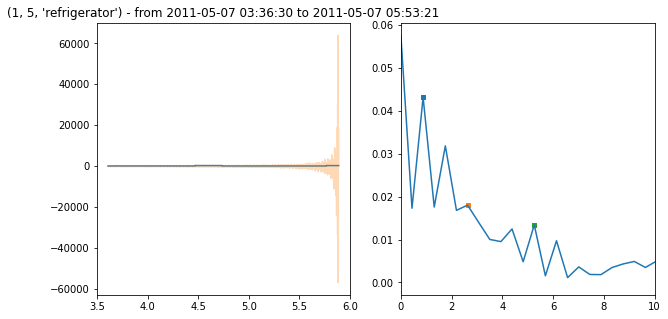

Peak at: 0.8603692417996056 	Magnitude: 0.009715844490288266 	Phase: 0.7741688711088203 PI
Peak at: 1.2905538626994084 	Magnitude: 0.0046391045825359065 	Phase: 0.5507211251815433 PI
Peak at: 1.6131923283742604 	Magnitude: 0.008205632692519829 	Phase: 0.5578219701139179 PI


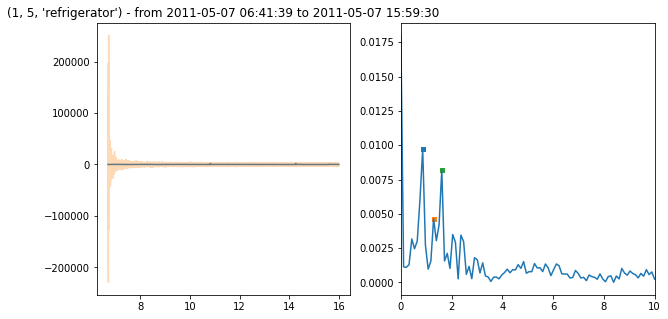

Peak at: 0.8097165991902835 	Magnitude: 0.0027652074961117983 	Phase: -0.5565878270345305 PI
Peak at: 1.619433198380567 	Magnitude: 0.0013227171375512303 	Phase: 0.9625684029769647 PI


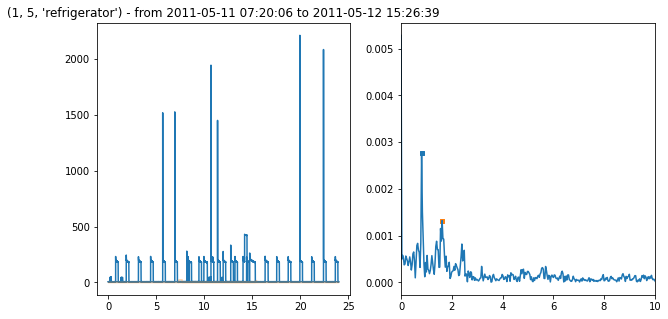

Peak at: 0.7863695937090432 	Magnitude: 0.01768044453479059 	Phase: -0.1995314386016349 PI
Peak at: 1.7300131061598951 	Magnitude: 0.011033164170935597 	Phase: 0.591661189976682 PI
Peak at: 2.5163826998689385 	Magnitude: 0.009781718043214241 	Phase: 0.42751141168216544 PI


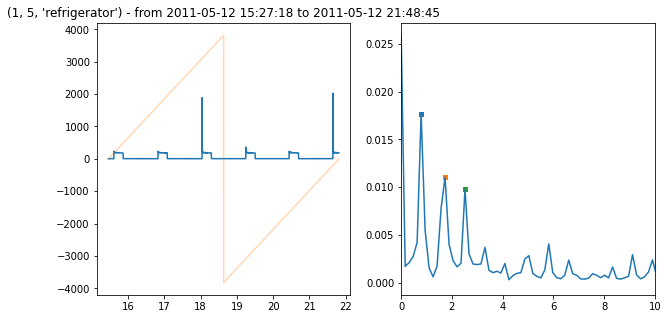

Peak at: 0.774693350548741 	Magnitude: 0.011494177778138394 	Phase: 0.5866597035307134 PI
Peak at: 1.6600571797473023 	Magnitude: 0.01074024483346957 	Phase: 0.02232083866799826 PI
Peak at: 2.4347505302960433 	Magnitude: 0.004885382794593901 	Phase: 0.5173305631116505 PI


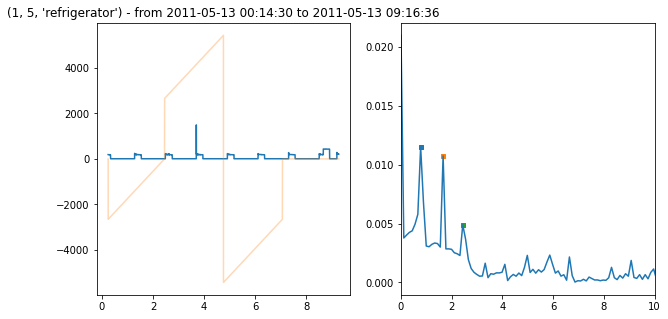

Peak at: 0.2640845070422535 	Magnitude: 0.014112806150737069 	Phase: 0.3998240619332703 PI
Peak at: 0.7922535211267605 	Magnitude: 0.01576248682446237 	Phase: -0.2886673988405011 PI


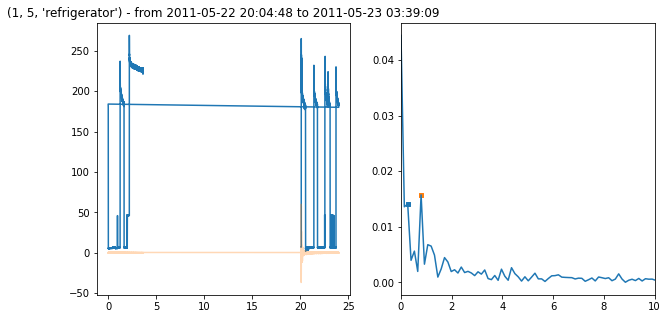

Peak at: 0.31018438738583487 	Magnitude: 0.005422794087825795 	Phase: -0.2516276428072131 PI
Peak at: 0.8271583663622264 	Magnitude: 0.009868601963656772 	Phase: -0.4708489857881241 PI
Peak at: 1.3441323453386178 	Magnitude: 0.004369428886011619 	Phase: -0.15434196184346538 PI


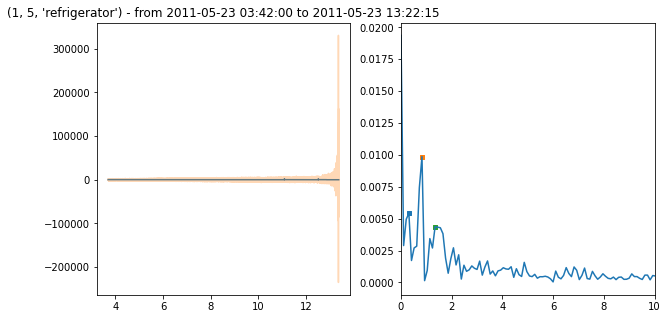

Peak at: 0.7139669790272198 	Magnitude: 0.00188730325403424 	Phase: -0.7066475701743696 PI
Peak at: 0.8210620258813028 	Magnitude: 0.0028216841367360375 	Phase: 0.3674871987744525 PI
Peak at: 1.5350290049085227 	Magnitude: 0.001619540389739991 	Phase: -0.34680165939766416 PI


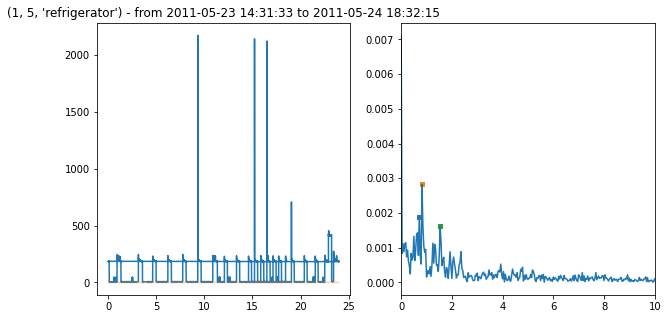

Peak at: 1.3447889428464699 	Magnitude: 0.054397907362975104 	Phase: 0.6095783023902982 PI


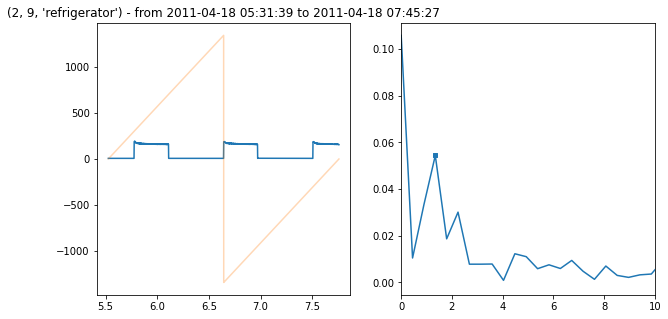

Peak at: 1.1703410928316609 	Magnitude: 0.003943391434876243 	Phase: 0.06055995394846126 PI


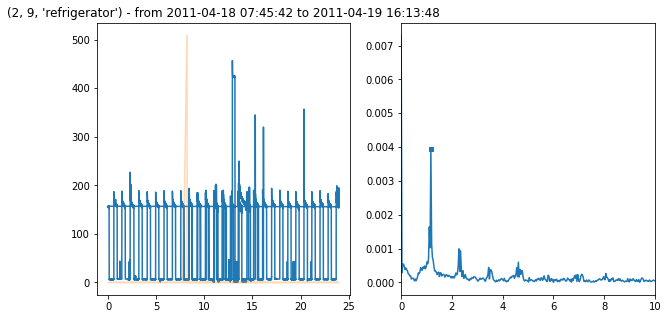

Peak at: 1.0737568707656908 	Magnitude: 0.015377370470543186 	Phase: -0.3019644939960652 PI


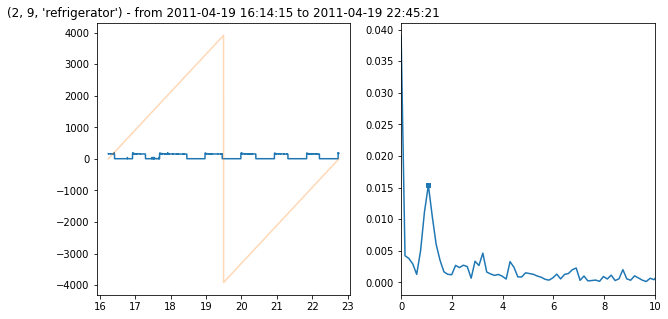

Peak at: 1.1448280923201115 	Magnitude: 0.0026749539121888465 	Phase: -0.8126008743130793 PI


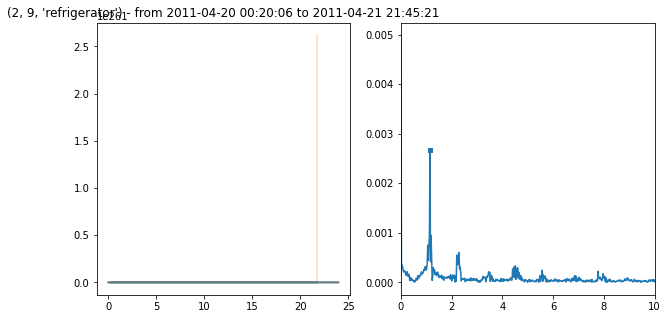

Peak at: 1.0855518221762728 	Magnitude: 0.01791876857697646 	Phase: 0.3245559562880562 PI
Peak at: 2.326182476092013 	Magnitude: 0.009724598059125 	Phase: -0.3695531764968934 PI


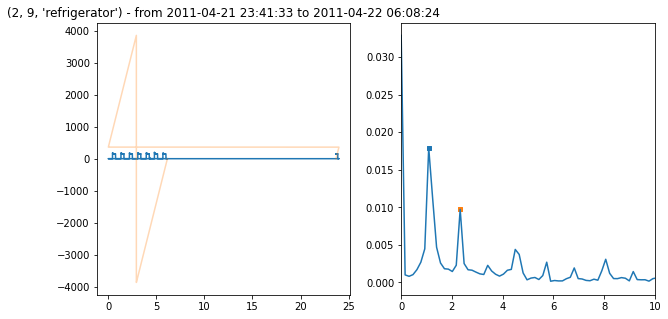

Peak at: 1.16537854570469 	Magnitude: 0.004932645866239092 	Phase: 0.2041095521215559 PI


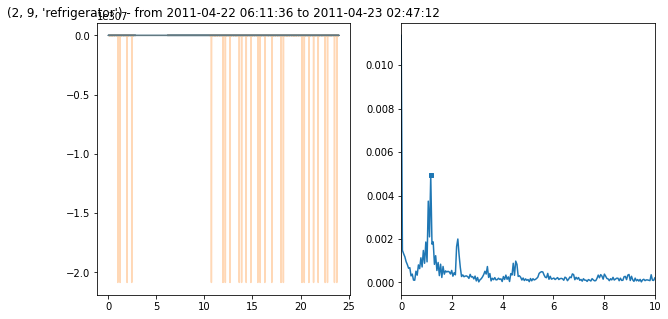

Peak at: 1.1044977603239858 	Magnitude: 0.010294393494960538 	Phase: 0.2412974439726016 PI
Peak at: 2.2089955206479717 	Magnitude: 0.004048461301056665 	Phase: 0.4884694618793676 PI


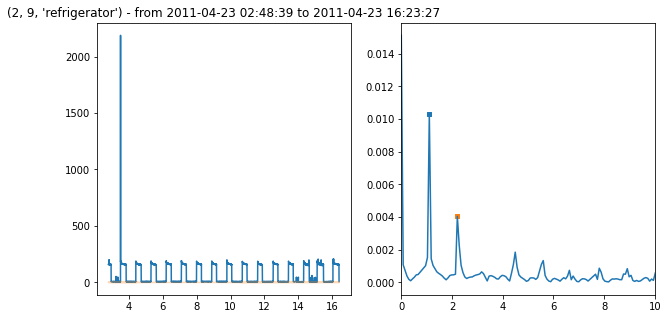

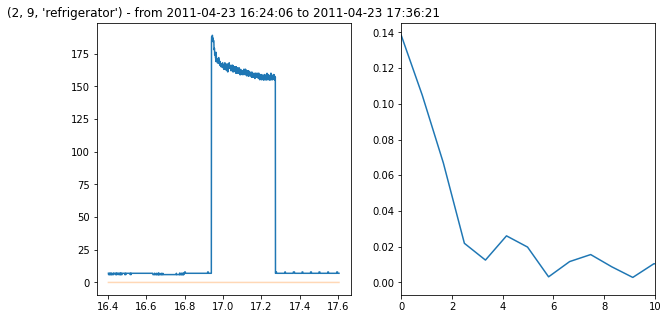

Peak at: 1.4934660858742999 	Magnitude: 0.07645475082497677 	Phase: 0.5560398025296807 PI


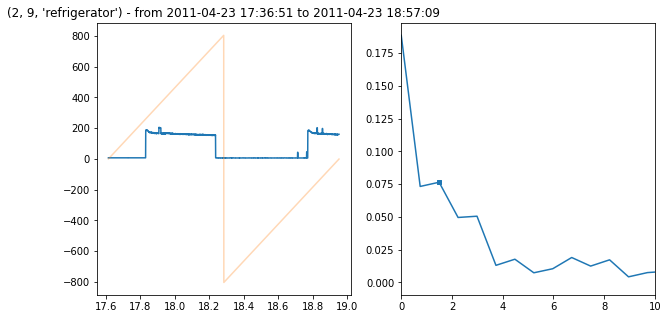

Peak at: 0.9592326139088729 	Magnitude: 0.05964812304471104 	Phase: 0.23499845704736472 PI
Peak at: 2.3980815347721824 	Magnitude: 0.029894933812634604 	Phase: -0.5590403478768854 PI


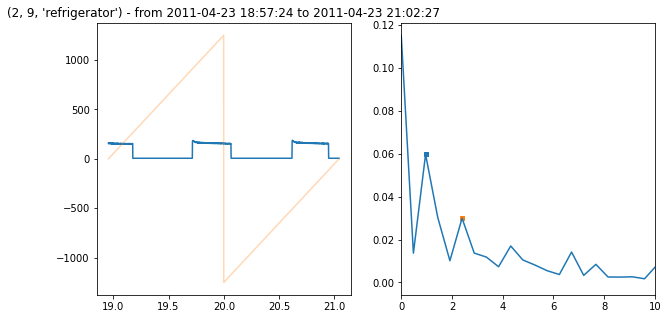

Peak at: 1.1191335740072201 	Magnitude: 0.003171682804226403 	Phase: -0.7565138110146117 PI


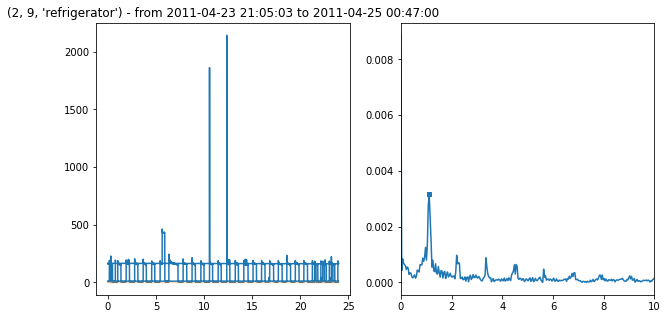

Peak at: 0.9706239199970585 	Magnitude: 0.005249776623868714 	Phase: 0.33637555189352036 PI


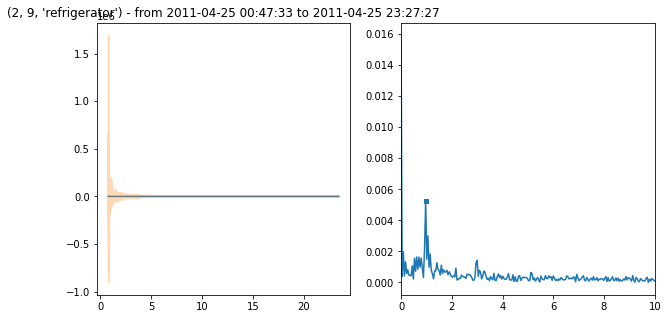

Peak at: 1.0074509392381152 	Magnitude: 0.0024851731933504865 	Phase: -0.29654952652206196 PI
Peak at: 1.1333823066428796 	Magnitude: 0.0021860264332875636 	Phase: -0.7420496781122617 PI


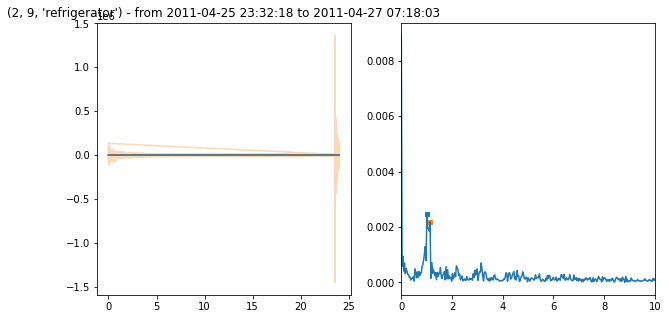

Peak at: 1.0993995997331554 	Magnitude: 0.0009066874029268975 	Phase: -0.4379430880170748 PI


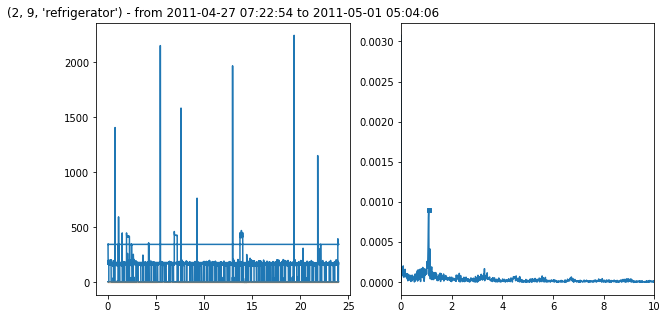

Peak at: 1.0510948905109487 	Magnitude: 0.058078754445758864 	Phase: 0.9160930105055373 PI
Peak at: 2.8029197080291968 	Magnitude: 0.029033027873034387 	Phase: 0.73398947494985 PI


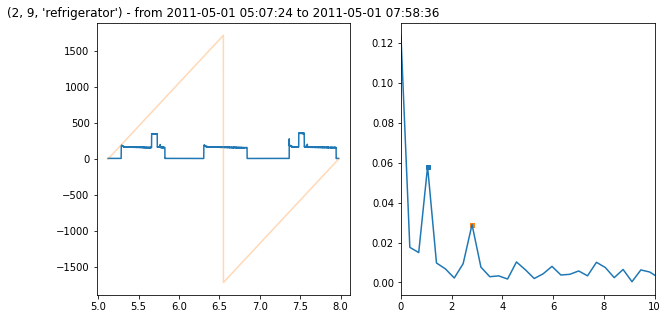

Peak at: 1.0351402887496595 	Magnitude: 0.005749569706134501 	Phase: -0.17550722027922233 PI


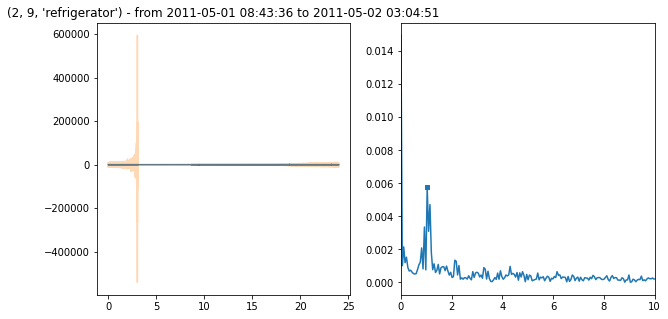

Peak at: 0.9925558312655086 	Magnitude: 0.04139677321734321 	Phase: 0.18593232242980182 PI


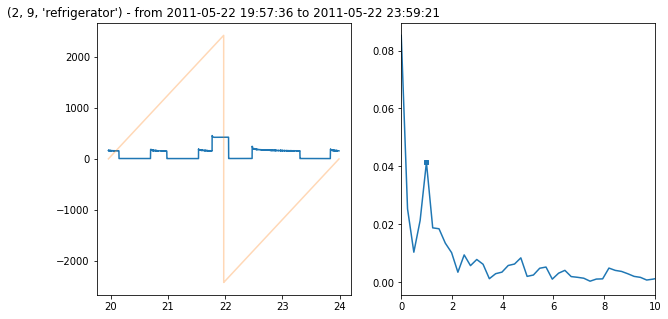

Peak at: 0.42923572195063786 	Magnitude: 0.0049941109015979555 	Phase: -0.06609774118372841 PI
Peak at: 1.7169428878025514 	Magnitude: 0.01576623411563837 	Phase: 0.2889984079420863 PI
Peak at: 3.290807201621557 	Magnitude: 0.006301104849021025 	Phase: -0.3331592558180441 PI


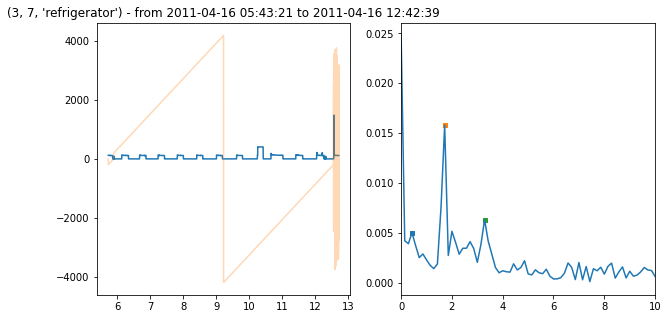

Peak at: 1.5298317185109636 	Magnitude: 0.012601806131603045 	Phase: -0.7759956064454386 PI
Peak at: 3.059663437021927 	Magnitude: 0.006009164828735844 	Phase: 0.5676983010329802 PI


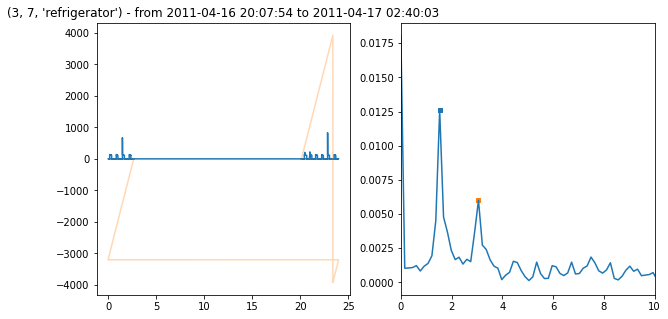

Peak at: 1.5440703409822 	Magnitude: 0.02608166324287986 	Phase: -0.16736090042559634 PI
Peak at: 3.0881406819644 	Magnitude: 0.010529209747406508 	Phase: -0.310314802414946 PI


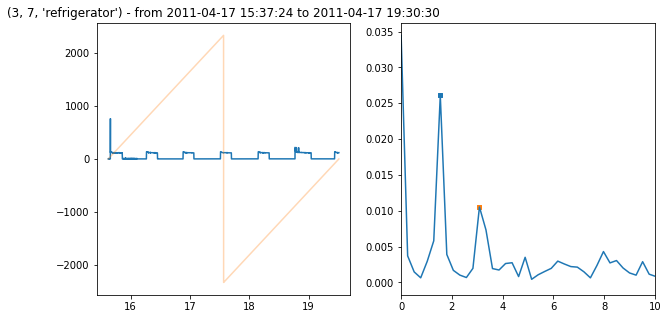

Peak at: 1.4229249011857708 	Magnitude: 0.033202666776708245 	Phase: 0.5427908322714958 PI
Peak at: 3.3201581027667983 	Magnitude: 0.020357075041154086 	Phase: -0.03758225832496879 PI


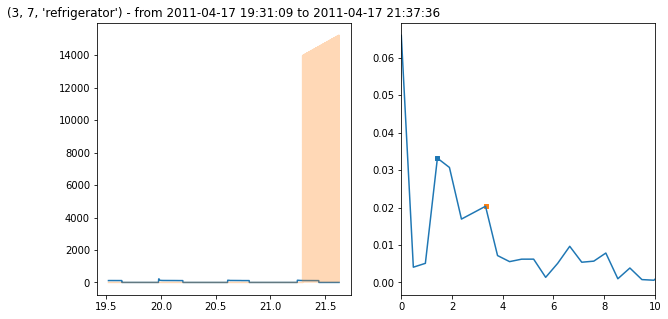

Peak at: 2.0969855832241153 	Magnitude: 0.021827478943961854 	Phase: 0.6730945593648442 PI


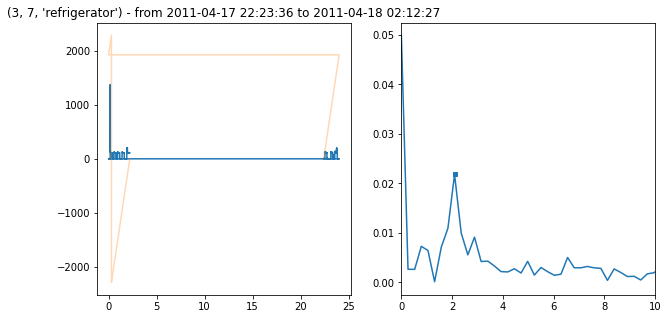

Peak at: 1.751824817518248 	Magnitude: 0.09305013340200749 	Phase: 0.8969607211046489 PI


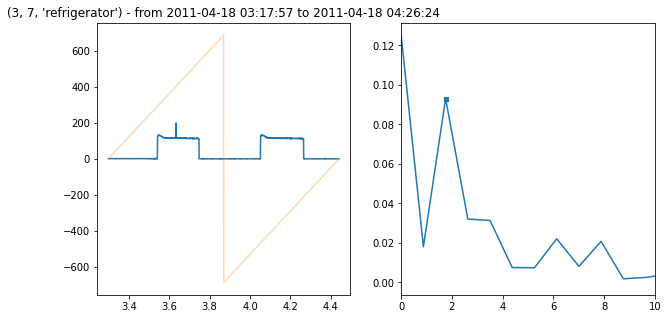

Peak at: 1.6765630457561995 	Magnitude: 0.06925282788354668 	Phase: 0.5497127190694335 PI


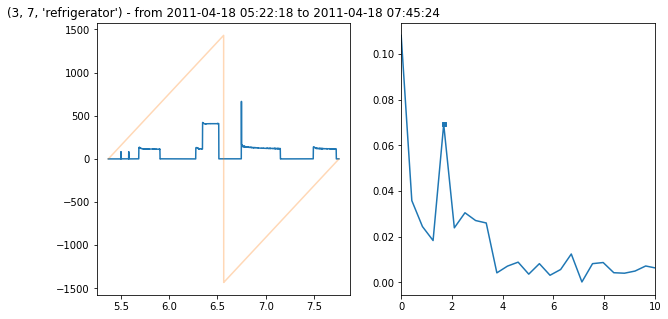

Peak at: 1.6647398843930634 	Magnitude: 0.029055706292901187 	Phase: 0.5161844824899423 PI
Peak at: 3.329479768786127 	Magnitude: 0.012684029702273053 	Phase: -0.9562793666622385 PI


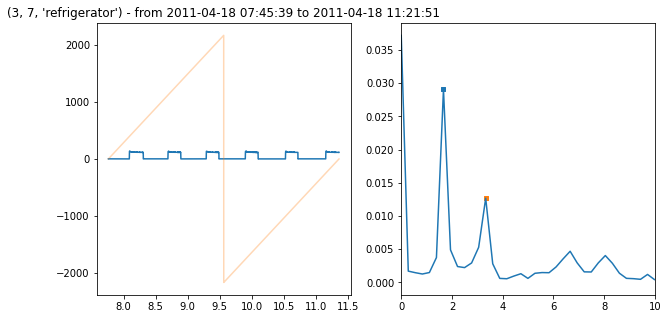

Peak at: 1.8461538461538458 	Magnitude: 0.07036235167364858 	Phase: 0.5552059848296459 PI


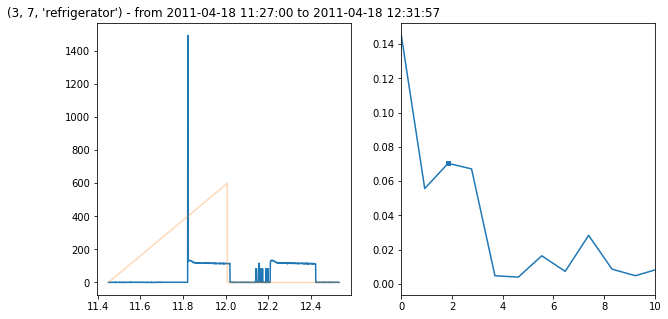

Peak at: 1.7937219730941705 	Magnitude: 0.09165379836205557 	Phase: -0.6224100655596542 PI


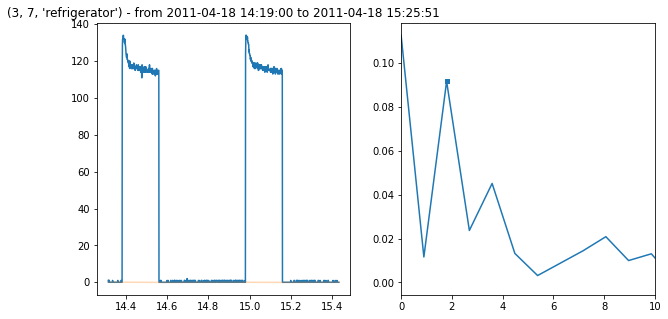

Peak at: 1.895734597156398 	Magnitude: 0.06069174407993187 	Phase: -0.05949938792905951 PI
Peak at: 8.53080568720379 	Magnitude: 0.021990166057055692 	Phase: -0.2664289273380188 PI
Peak at: 13.270142180094785 	Magnitude: 0.015209499010309383 	Phase: -0.4165603610369616 PI


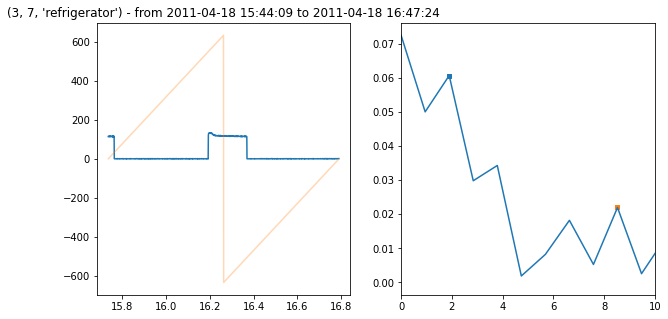

Peak at: 1.569448077426105 	Magnitude: 0.02735872507569289 	Phase: -0.7985514795209688 PI
Peak at: 3.4527857703374307 	Magnitude: 0.014139085477698873 	Phase: -0.3495272001932785 PI


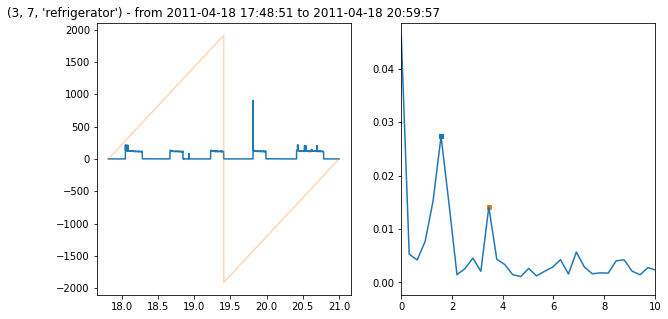

Peak at: 1.8362662586074978 	Magnitude: 0.09944506783242817 	Phase: -0.44689162733410714 PI
Peak at: 7.345065034429991 	Magnitude: 0.02630990607732651 	Phase: -0.8054970679011425 PI


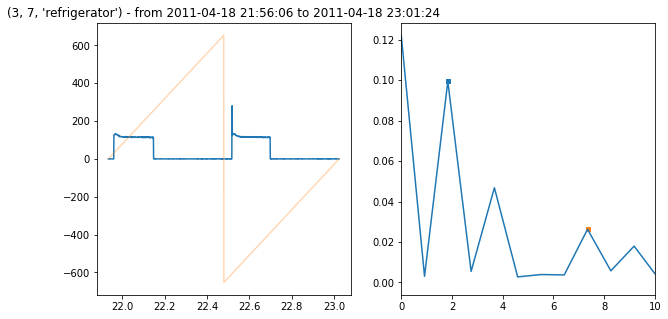

Peak at: 1.8329005651443409 	Magnitude: 0.020660783847722217 	Phase: -0.6149526614943326 PI


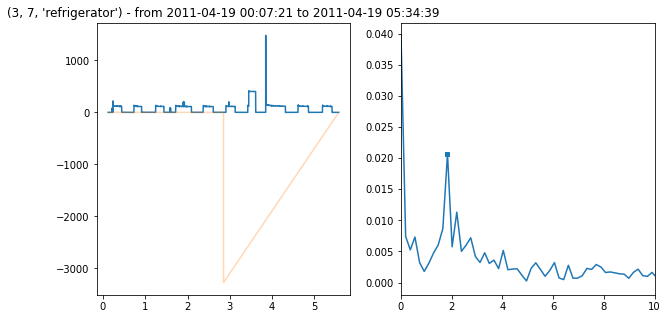

Peak at: 1.5535417051969669 	Magnitude: 0.01799533964157039 	Phase: 0.8472514397063627 PI
Peak at: 3.1070834103939338 	Magnitude: 0.008994926413449759 	Phase: -0.3031135316227619 PI


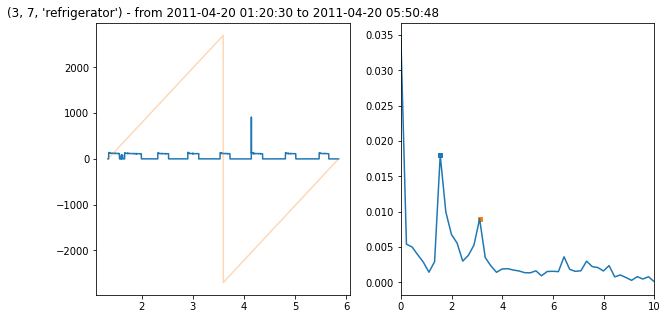

Peak at: 1.6167059616032335 	Magnitude: 0.038002155712950195 	Phase: -0.29674126010841706 PI
Peak at: 3.233411923206467 	Magnitude: 0.021967825440841 	Phase: -0.592779146615334 PI


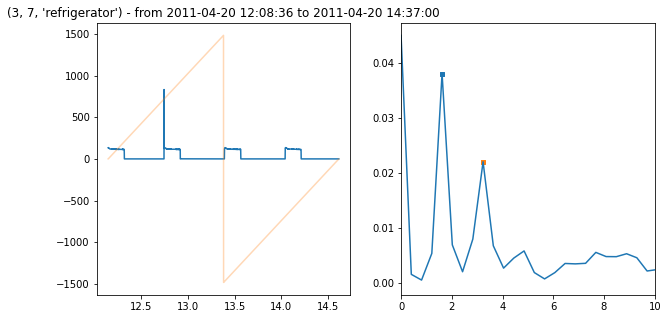

Peak at: 1.4359792580773831 	Magnitude: 0.04220776583969313 	Phase: 0.760990518941359 PI
Peak at: 2.8719585161547663 	Magnitude: 0.02683541942209988 	Phase: -0.4802586663172843 PI
Peak at: 4.307937774232149 	Magnitude: 0.010054574788056603 	Phase: 0.26556274020342674 PI


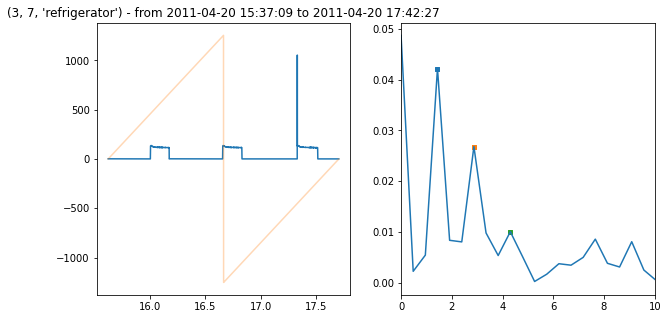

Peak at: 1.6401723369484476 	Magnitude: 0.0019456786628205814 	Phase: 0.8907881840931332 PI


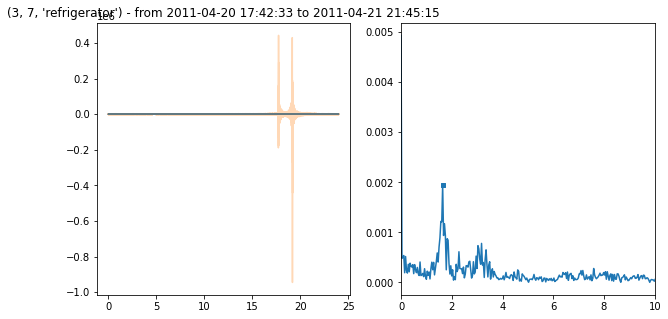

Peak at: 1.546676486834837 	Magnitude: 0.020496951211352765 	Phase: -0.6977191860947517 PI
Peak at: 2.209537838335481 	Magnitude: 0.012470313772808526 	Phase: 0.7412002003190229 PI


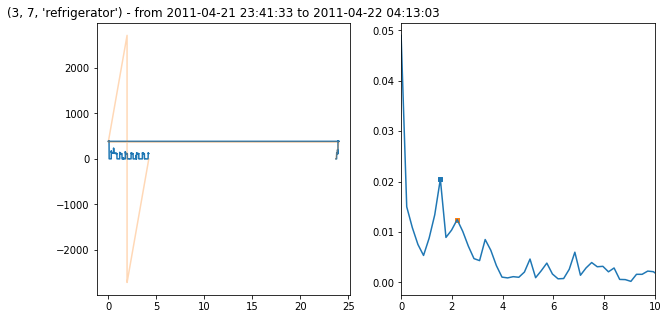

Peak at: 1.408450704225352 	Magnitude: 0.036174855319232924 	Phase: 0.03629587180330256 PI
Peak at: 2.816901408450704 	Magnitude: 0.018024810447794432 	Phase: 0.09223063718625125 PI


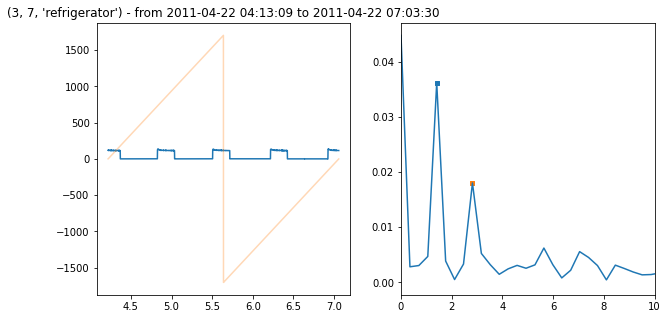

Peak at: 1.3329101872421454 	Magnitude: 0.017894788007322634 	Phase: -0.025650999908276035 PI
Peak at: 2.6658203744842908 	Magnitude: 0.008449368665935557 	Phase: -0.02406223288911892 PI


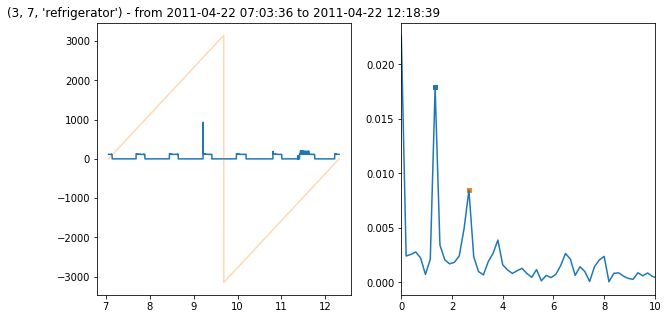

Peak at: 1.5223596574690772 	Magnitude: 0.02455769882133406 	Phase: -0.2745212751292318 PI
Peak at: 2.664129400570885 	Magnitude: 0.01781595031580721 	Phase: 0.40077767465602454 PI
Peak at: 3.805899143672693 	Magnitude: 0.008945278164012492 	Phase: -0.6046495505991135 PI


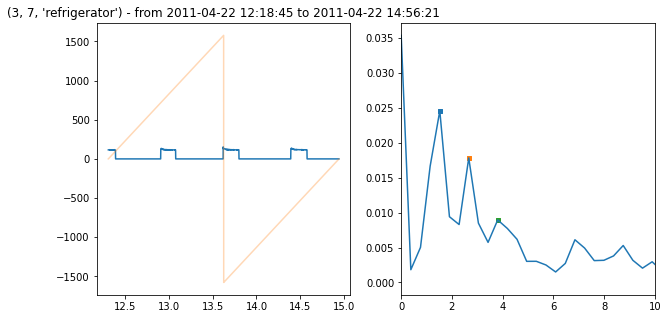

Peak at: 1.4088641033167009 	Magnitude: 0.007420308210170632 	Phase: -0.9785635951904166 PI
Peak at: 1.8784854710889345 	Magnitude: 0.007261173149151431 	Phase: -0.2972685877504062 PI


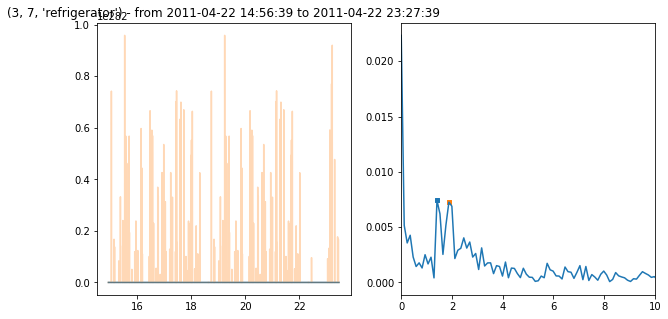

Peak at: 1.8054162487462384 	Magnitude: 0.02728178012040713 	Phase: 0.576509540806489 PI
Peak at: 3.309929789368104 	Magnitude: 0.013606622547719672 	Phase: 0.2437864896354087 PI


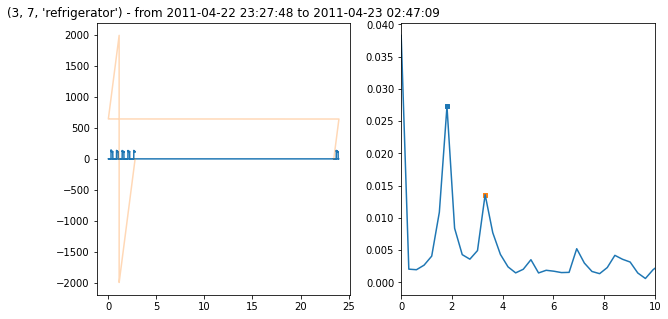

Peak at: 1.5788175314530055 	Magnitude: 0.0070968685918767465 	Phase: 0.2539609311521314 PI
Peak at: 3.058958967190198 	Magnitude: 0.004024812263724238 	Phase: -0.5002257173683254 PI


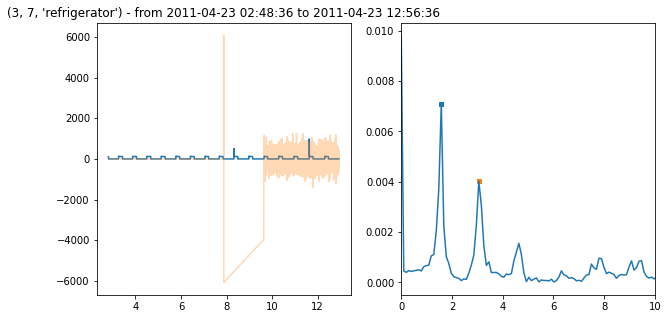

Peak at: 1.4354753815972054 	Magnitude: 0.0047536123451089535 	Phase: -0.25457673519062074 PI
Peak at: 2.870950763194411 	Magnitude: 0.002285943111810234 	Phase: -0.48300582842161277 PI


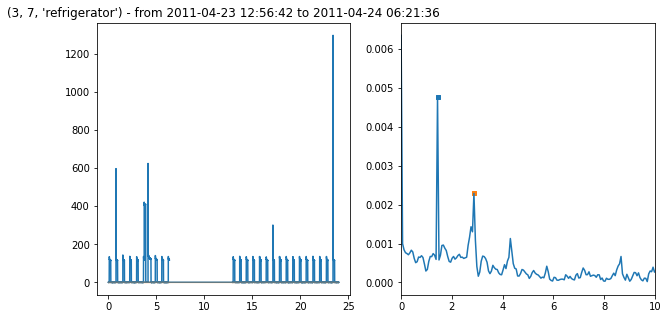

Peak at: 1.4630902238971404 	Magnitude: 0.0049665039644003536 	Phase: -0.20811072983157922 PI
Peak at: 2.9261804477942808 	Magnitude: 0.002372016590370926 	Phase: -0.4689644580392243 PI


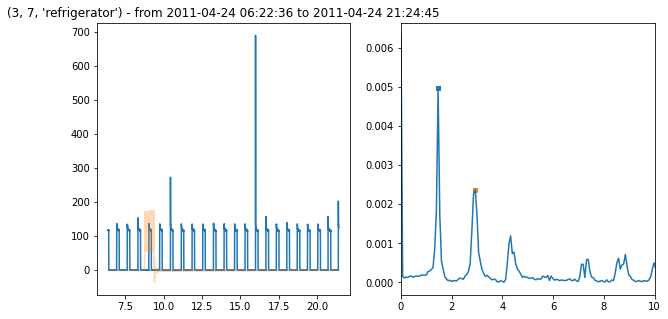

Peak at: 1.6260162601626016 	Magnitude: 0.01543359239787478 	Phase: -0.9690912609161358 PI
Peak at: 3.252032520325203 	Magnitude: 0.008011137081162228 	Phase: 0.06517826843598037 PI


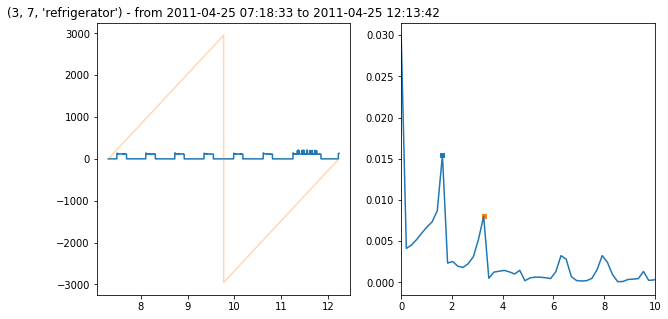

Peak at: 1.7357222844344906 	Magnitude: 0.0012576027529119518 	Phase: -0.8670703147669299 PI
Peak at: 1.8477043673012319 	Magnitude: 0.0014594106404679835 	Phase: 0.475331998283678 PI


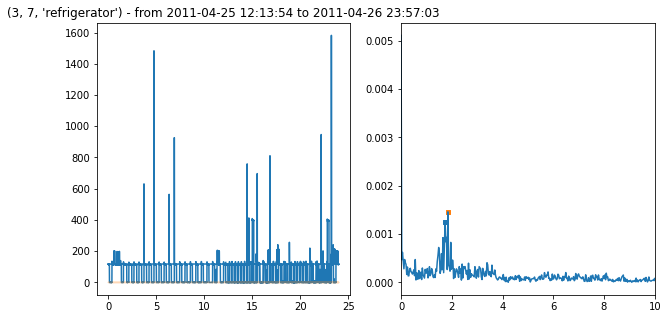

Peak at: 1.6313583323892602 	Magnitude: 0.010339618325571849 	Phase: -0.9688167882221681 PI
Peak at: 3.126770137079415 	Magnitude: 0.006395903135570067 	Phase: -0.7544230455848233 PI


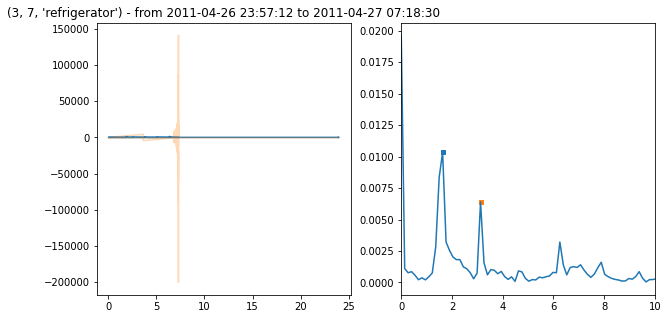

Peak at: 0.3293084522502744 	Magnitude: 0.003940656700337882 	Phase: -0.9409485419914372 PI
Peak at: 1.4270032930845225 	Magnitude: 0.00784697315505443 	Phase: -0.5462983843867744 PI
Peak at: 1.8660812294182216 	Magnitude: 0.004021140014253732 	Phase: 0.2460461008329224 PI
Peak at: 3.0735455543358943 	Magnitude: 0.003755308267577974 	Phase: -0.44058524653799636 PI


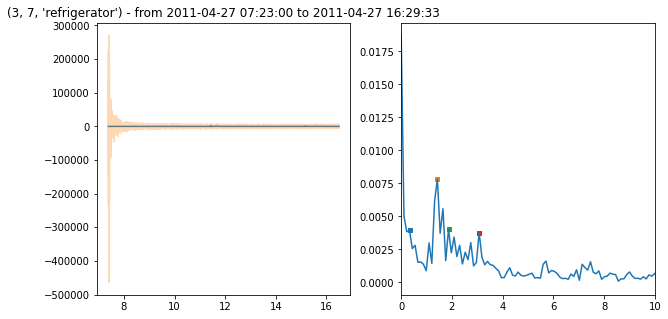

Peak at: 1.46163215590743 	Magnitude: 0.07905742874632668 	Phase: -0.34520956760662497 PI
Peak at: 5.115712545676004 	Magnitude: 0.0268280999044041 	Phase: 0.7616143495280736 PI


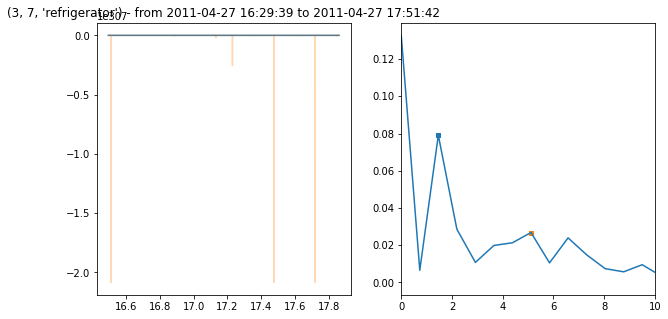

Peak at: 1.7552785550750445 	Magnitude: 0.004596261433620504 	Phase: 0.0018864019538572098 PI


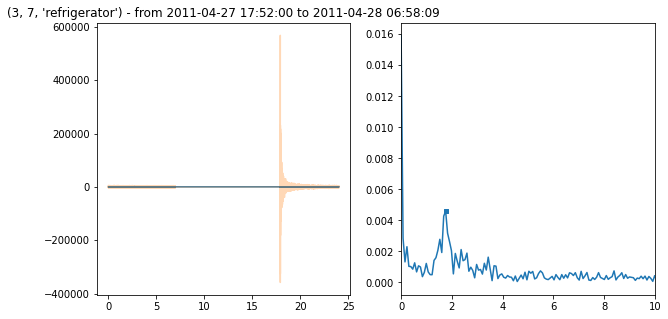

Peak at: 1.5800561797752808 	Magnitude: 0.00676276819524822 	Phase: -0.24377958277777012 PI


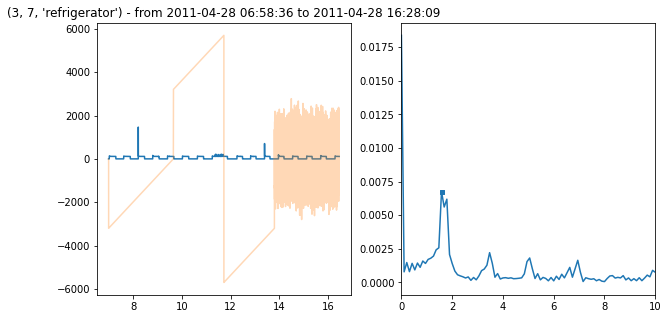

Peak at: 1.522166550390055 	Magnitude: 0.003997840946809168 	Phase: 0.31477578250258254 PI
Peak at: 1.826599860468066 	Magnitude: 0.0021320600670619977 	Phase: -0.09971051605009461 PI


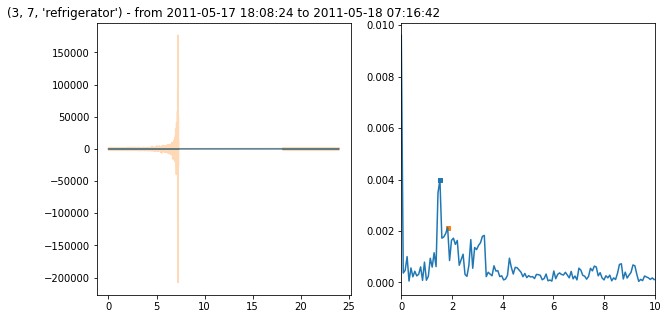

Peak at: 1.5980975029726514 	Magnitude: 0.0037567672099300914 	Phase: 0.5432563329047818 PI
Peak at: 3.082045184304399 	Magnitude: 0.0017515492972362925 	Phase: -0.8714088739021726 PI


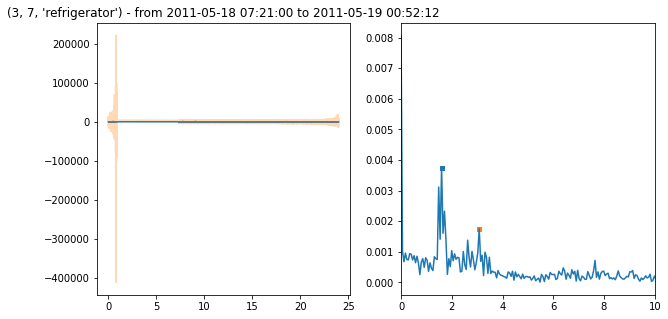

Peak at: 1.1302337528898023 	Magnitude: 0.005275485451257332 	Phase: -0.46367014076575236 PI
Peak at: 1.6439763678397123 	Magnitude: 0.004680798783856398 	Phase: 0.45481019041530873 PI
Peak at: 2.3632160287695867 	Magnitude: 0.0045133967883936275 	Phase: -0.07707228735637864 PI


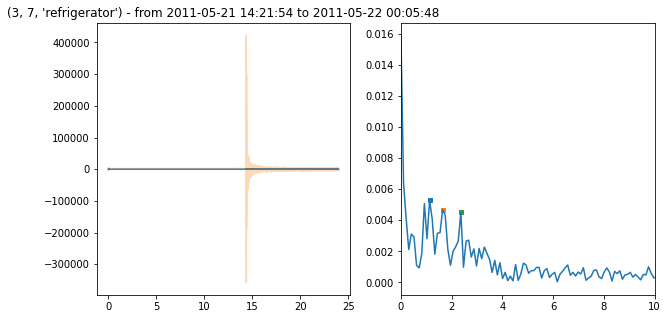

Peak at: 1.5966546283976428 	Magnitude: 0.0031970722396233026 	Phase: -0.047092767495282656 PI
Peak at: 1.8247481467401632 	Magnitude: 0.002034700117201869 	Phase: -0.5685901724901383 PI
Peak at: 2.1668884242539437 	Magnitude: 0.0017535324662216589 	Phase: -0.7948245205939276 PI


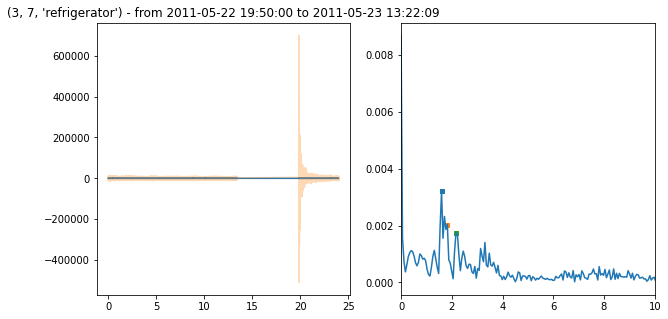

Peak at: 1.5351203403445095 	Magnitude: 0.001635733150128956 	Phase: -0.15690209445674633 PI
Peak at: 1.6422217594383126 	Magnitude: 0.0013105524856344098 	Phase: 0.9245855889846427 PI


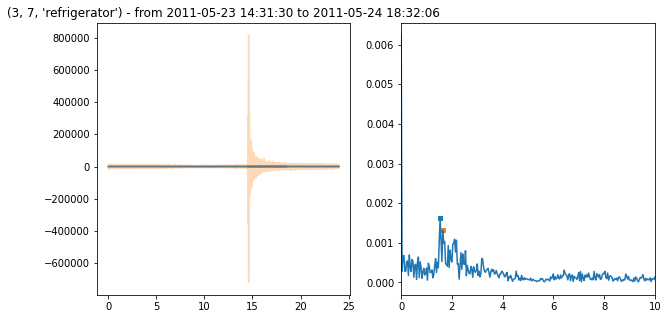

Peak at: 1.7507517540928834 	Magnitude: 0.0006119729788134967 	Phase: 0.7231704490750963 PI


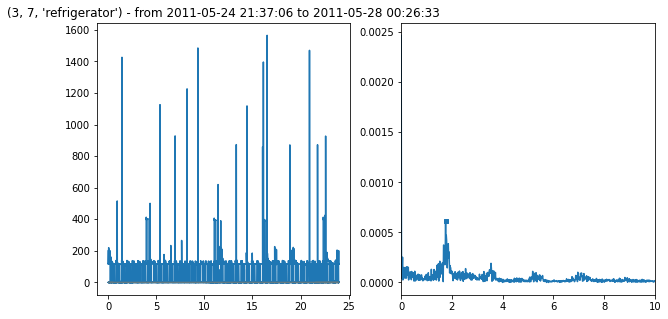

Peak at: 1.0084033613445378 	Magnitude: 0.01840998240208329 	Phase: -0.21987788067002015 PI
Peak at: 1.6806722689075628 	Magnitude: 0.009139322273947838 	Phase: 0.5431868756684068 PI
Peak at: 2.1848739495798317 	Magnitude: 0.01578301303601341 	Phase: 0.43663881034838536 PI


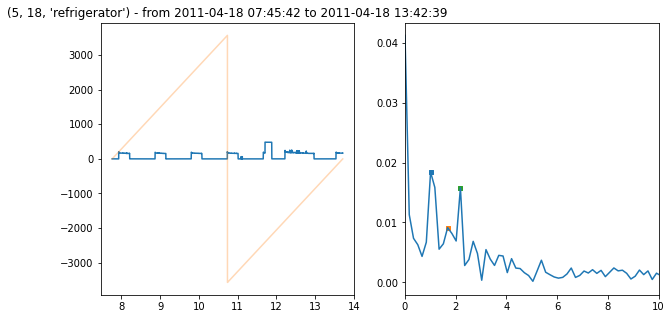

Peak at: 1.0529086601737299 	Magnitude: 0.012843086953288715 	Phase: 0.32294225926165654 PI
Peak at: 2.2111081863648328 	Magnitude: 0.006089101805138655 	Phase: -0.027110474636669737 PI


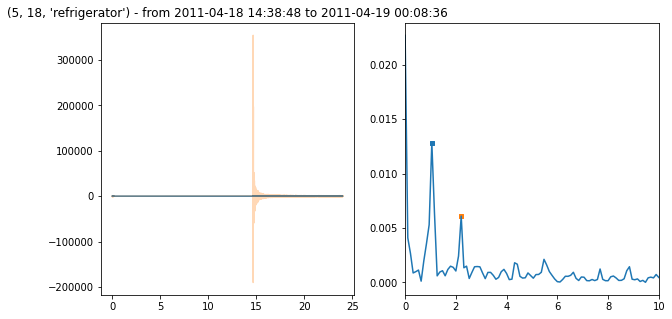

Peak at: 1.2834224598930482 	Magnitude: 0.08006278944576864 	Phase: -0.47087176995101737 PI


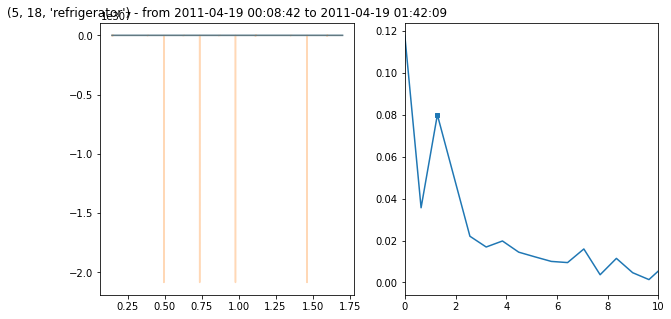

Peak at: 1.1001100110011002 	Magnitude: 0.029978051385128608 	Phase: -0.30907051508494077 PI
Peak at: 2.2002200220022003 	Magnitude: 0.014671062132123174 	Phase: -0.6040588126682797 PI


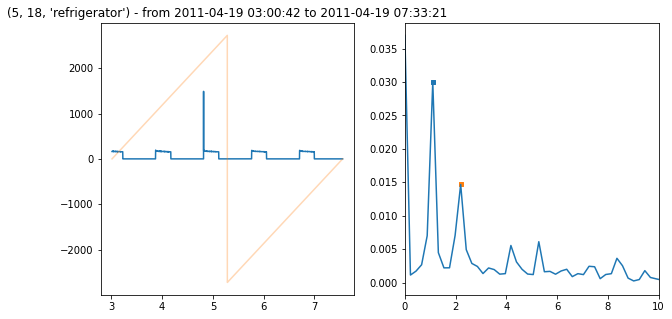

Peak at: 1.1780104712041883 	Magnitude: 0.07530240518491646 	Phase: -0.5810208856162951 PI
Peak at: 2.3560209424083767 	Magnitude: 0.03406973840301989 	Phase: 0.476657731205925 PI


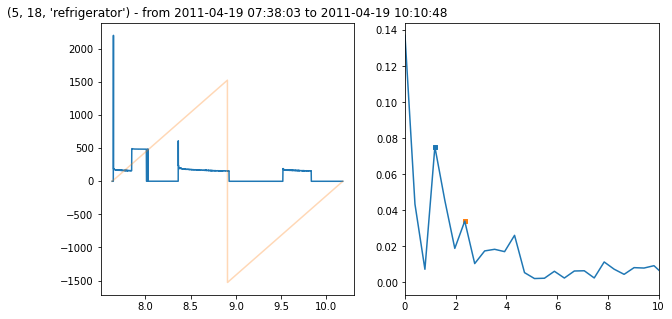

Peak at: 1.0398613518197573 	Magnitude: 0.0687437792935314 	Phase: 0.9851632478358345 PI
Peak at: 4.679376083188908 	Magnitude: 0.01964669594360673 	Phase: -0.10839393248177265 PI


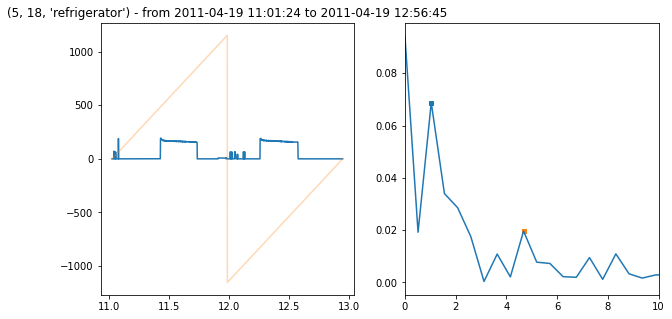

Peak at: 1.3644115974985787 	Magnitude: 0.06457739254688592 	Phase: 0.2522008479002265 PI
Peak at: 5.457646389994315 	Magnitude: 0.023914978976578037 	Phase: 0.1718508030303856 PI


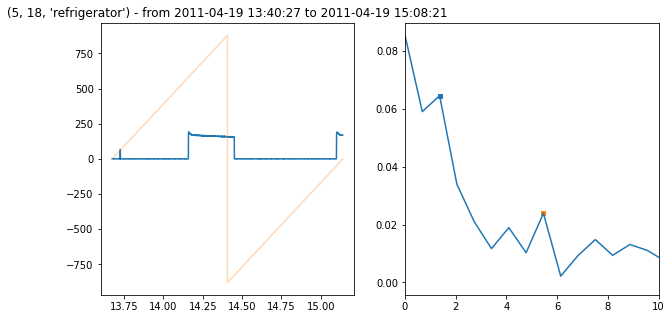

Peak at: 0.9211087420042644 	Magnitude: 0.012884222238702697 	Phase: 0.5454870652660216 PI
Peak at: 1.8422174840085288 	Magnitude: 0.005728597705391486 	Phase: 0.9384652675378223 PI


In [485]:
# perform fft on signals

for c in [c for c in channels if c[2] == "refrigerator"]:
    for y in channels[c]:
        x = index_to_hours(y)
        N = len(x)
        T = 1200 # samples per hour 
        fig = plt.figure()
        fig.set_size_inches(10,5)
        ax1 = fig.add_subplot(1,2,1) # signal
        ax2 = fig.add_subplot(1,2,2) # freqs
        ax1.plot(x,y)
        ax1.set_title("{} - from {} to {}".format(c,y.index[0],y.index[-1]))
        # plt.show()   
        yf = np.fft.fft(y)[:N//2] * 2./N
        v1 = abs(yf[:N//2]) * 2./N
        xf = np.fft.fftfreq(N, d=1/T)[0:N//2]
        peaks = peakutils.indexes(v1, thres=0.2, min_dist=2)
        params = []
        for p in peaks:
            freq, ampl, phase = par = (xf[p], v1[p], np.angle(yf[p]))
            params.append(par)
            print("Peak at:", freq, "\tMagnitude:", ampl, "\tPhase:", phase/ np.pi, 'PI')
            ax2.scatter(xf[p], v1[p], s=10, marker='s')
        # reconstruct
        signal = np.empty(N, dtype='float64')
        for (f,a,p) in params:
            signal += a * np.sin(f*np.array(x) * 2 * np.pi + p)
        # print(peaks)
        ax1.plot(x,signal, alpha=0.3)
        ax2.plot(xf,v1)
        ax2.set_xlim([0,10])
        plt.show()

